# Autotrader_1_scraping_cleaning
---

In [1]:
# import packages
import numpy as np
import pandas as pd
import re
import math as math
import bs4
from bs4 import BeautifulSoup, SoupStrainer
import requests
import cloudscraper
from tqdm import tqdm
from time import time, sleep
import random

from selenium import webdriver
from time import time, sleep

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import pickle
import ast
import regex as re

# import packages
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## List of car_makes from Autotrader site
---

In [2]:
filepath = '../data/autotrader_carmakes.xlsx'

df_carmakes = pd.read_excel(filepath)
df_carmakes = df_carmakes[df_carmakes['Car Manufacturers'] != 'All makes']
df_carmakes.head(3)

,Car Manufacturers
0,"Audi (36,939)"
1,"BMW (38,230)"
2,"Ford (45,488)"


In [3]:
# make column and number of cars for each make
def split_make(x):
    return '+'.join(x.split()[0:-1])

def split_number(x):
    return int(x.split()[-1].replace('(','').replace(')','').replace(',',''))

df_carmakes['make'] = df_carmakes['Car Manufacturers'].apply(lambda x: split_make(x))
df_carmakes['count_avail'] = df_carmakes['Car Manufacturers'].apply(lambda x: split_number(x))

df_carmakes.head(3)

,Car Manufacturers,make,count_avail
0,"Audi (36,939)",Audi,36939
1,"BMW (38,230)",BMW,38230
2,"Ford (45,488)",Ford,45488


In [4]:
make_list = list(df_carmakes.make)
print(len(make_list))
print(make_list[:3])
df_carmakes[:10]

125
['Audi', 'BMW', 'Ford']


,Car Manufacturers,make,count_avail
0,"Audi (36,939)",Audi,36939
1,"BMW (38,230)",BMW,38230
2,"Ford (45,488)",Ford,45488
3,"Honda (9,501)",Honda,9501
4,"Jaguar (7,754)",Jaguar,7754
5,"Land Rover (15,604)",Land+Rover,15604
6,"Mercedes-Benz (33,307)",Mercedes-Benz,33307
7,"Nissan (21,452)",Nissan,21452
8,"Porsche (4,334)",Porsche,4334
9,"Toyota (18,243)",Toyota,18243


## Define Scraper Functions
---

In [5]:
# Define scraper functions
def scrape_total_pages():
    """scrape total number of pages from url (eg: "Page 1 of 3664") """
    try:
        return soup.find('li', attrs={'class':'paginationMini__count'}).get_text().strip()
    except:
        return np.nan
    
def last_page():
    """output last_page (int) from scraped total pages str. Based on max 100 pages shown per search. """
    total_pages_str = scrape_total_pages()
    try:
        if int(total_pages_str.split()[-1]) > 100:
            last_page = 100
        else:
            last_page = int(total_pages_str.split()[-1])
    except:
        last_page = 100
    return last_page

def scrape_total_cars():
    """scrape total number of cars found from search criteria (eg '36,640 cars found') """
    try:
        return soup.find('h1', attrs={'class':'search-form__count js-results-count'}).get_text().strip()
    except:
        return np.nan

def scrape_header():
    """scrape header information (eg 'Volkswagen Golf 1.9 TDI S 5dr') """
    try:
        return car.h3.get_text().strip()
    except:
        return np.nan
    
def scrape_attngrab():
    """scrape attention grabbing subheading (eg '10 month MOT taxed until Nov20') """
    try:
        return car.find('p', attrs={'class':'product-card-details__attention-grabber'}).get_text().strip()
    except:
        return np.nan
    
def scrape_descr_list():
    """scrape descriptions of car (eg ['2012 (62 reg)', 'SUV', '67,441 miles', '2.0L', '138BHP', 
    'Manual', 'Diesel', 'Full service history']) """
    try:
        descr = []
        for string in car.ul.strings:
            if string != '\n':
                descr.append(string)
        return descr
    except:
        return np.nan
    
def scrape_seller_type():
    """scrape seller type (eg 'Trade seller - \nSee all 166 cars') """
    try:
        return car.find('div', attrs={'class':'product-card-seller__seller-type'}).get_text().strip()
    except:
        return np.nan

def scrape_seller_town():
    """scrape seller town location (eg 'edmonton') """
    try:
        return car.find('span', attrs={'class':'seller-town'}).get_text().strip()
    except:
        return np.nan

def scrape_seller_rating():
    """scrape seller rating (eg 4.7) """
    try:
        return car.find('p', attrs={'class':'product-card-seller__rating-number'}).get_text().strip()
    except:
        return np.nan

def scrape_price():
    """scrape price of car (eg £2,999) """
    try:
        return car.find('div', attrs={'class':'product-card-pricing__price'}).get_text().strip()
    except:
        return np.nan

def scrape_url():
    """scrape URL of car"""
    try:
        return car.find('a').get('href').strip()
    except:
        return np.nan

## Scrape Autotrader
---

In [6]:
# # scrape with search criteria
# postcode = 'wc2n5ls'
# make = 'volkswagen'
# page_num = 1


# # empty lists to populate through scrapes
# list_header = []
# list_attn_grab = []
# list_descriptions = []
# list_seller_type = []
# list_seller_town = []
# list_seller_rating = []
# list_price = []
# list_url = []


# print(make_list[110:])

# for make in make_list[110:]:
#     print(make)
#     page_num = 1

#     # set url with make iteration, instantiate scraper and soup, scrape and calculate final page number
#     url = f'https://www.autotrader.co.uk/car-search?sort=relevance&postcode={postcode}&radius=1500&make={make}&include-delivery-option=on&page={page_num}'
#     scraper = cloudscraper.create_scraper()
#     soup = BeautifulSoup(scraper.get(url).text, 'html.parser')
#     last_pg_ix = last_page() + 1


#     # iterate through pages of website resulting from search criteria
#     start = time()
#     while time()-start < random.randint(1,5):
#         continue

#     # iterate from page 1 to last_pg_ix, add delay
#     for page_num in tqdm(range(1, last_pg_ix, 1)):
#         start = time()
#         while time()-start < random.randint(1,3):
#             continue

#         # set url with the page_num iteration, and instantiate scraper and soup for that page_num url
#         url = f'https://www.autotrader.co.uk/car-search?sort=relevance&postcode={postcode}&radius=1500&make={make}&include-delivery-option=on&page={page_num}'
#         scraper = cloudscraper.create_scraper()
#         soup = BeautifulSoup(scraper.get(url).text, 'html.parser')

#         # iterate through product cards (ie cars in each page)
#         for car in soup.find_all('article'):
#             list_header.append(scrape_header())
#             list_attn_grab.append(scrape_attngrab())
#             list_descriptions.append(scrape_descr_list())
#             list_seller_type.append(scrape_seller_type())
#             list_seller_town.append(scrape_seller_town())
#             list_seller_rating.append(scrape_seller_rating())
#             list_price.append(scrape_price())
#             list_url.append(scrape_url())

    
# # populate dataframe with scraped lists of data
# df = pd.DataFrame({'header':list_header,
#                   'attn_grab':list_attn_grab, 
#                   'description':list_descriptions, 
#                   'seller_type':list_seller_type, 
#                   'seller_town':list_seller_town, 
#                   'seller_rating':list_seller_rating, 
#                   'price':list_price, 
#                   'url':list_url})
    
# df

In [7]:
# # visualise missing values
# fig, ax = plt.subplots(2,1, figsize=(16,10))

# msno.matrix(df, ax=ax[0])
# msno.bar(df, ax=ax[1]);

In [8]:
# # write to file

# to_file = '../data/df_110.csv'
# df.to_csv(to_file)

## Read and concatenate all scraped df
---

In [9]:
# concatenate all individually scraped df to one master df
df_5 = pd.read_csv('../data/df_5.csv', index_col=0)
df_10 = pd.read_csv('../data/df_10.csv', index_col=0)
df_15 = pd.read_csv('../data/df_15.csv', index_col=0)
df_20 = pd.read_csv('../data/df_20.csv', index_col=0)
df_25 = pd.read_csv('../data/df_25.csv', index_col=0)
df_30 = pd.read_csv('../data/df_30.csv', index_col=0)
df_35 = pd.read_csv('../data/df_35.csv', index_col=0)
df_40 = pd.read_csv('../data/df_40.csv', index_col=0)
df_50 = pd.read_csv('../data/df_50.csv', index_col=0)
df_60 = pd.read_csv('../data/df_60.csv', index_col=0)
df_70 = pd.read_csv('../data/df_70.csv', index_col=0)
df_80 = pd.read_csv('../data/df_80.csv', index_col=0)
df_90 = pd.read_csv('../data/df_90.csv', index_col=0)
df_100 = pd.read_csv('../data/df_100.csv', index_col=0)
df_110 = pd.read_csv('../data/df_110.csv', index_col=0)
df_125 = pd.read_csv('../data/df_125.csv', index_col=0)
df_volkswagen = pd.read_csv('../data/df_volkswagen.csv', index_col=0)

list_df = [df_5, df_10, df_15, df_20, df_25, df_30, df_35, df_40, df_50, df_60, df_70, df_80, df_90, df_100, df_110, df_125, df_volkswagen]
df_master = pd.concat(list_df)
print(df_master.shape)
df_master.head(3)

(62082, 8)


,header,attn_grab,description,seller_type,seller_town,seller_rating,price,url
0,NaN,NaN,"['2016 (16 reg)', 'Saloon', '77,798 miles', '2...",NaN,bristol,NaN,NaN,/car-details/202011045771574?postcode=wc2n5ls&...
1,NaN,NaN,"['2007 (57 reg)', 'Hatchback', '92,000 miles',...",NaN,ilford,NaN,NaN,/car-details/202010185157056?postcode=wc2n5ls&...
2,NaN,NaN,"['2008 (08 reg)', 'Hatchback', '101,000 miles'...",NaN,northolt,NaN,NaN,/car-details/202010044590175?postcode=wc2n5ls&...


In [10]:
# # write df_master to file

# to_file = '../data/df_master.csv'
# df_master.to_csv(to_file)

In [11]:
# rename columns to signify 'scraped columns' (for easier identification later)
col_rename = {'header':'scr_header', 'attn_grab':'scr_attngrab', 'description':'scr_descr', 
              'seller_type':'scr_sellertype', 'seller_town':'scr_sellertown',
              'seller_rating':'scr_sellerrating', 'price':'scr_price', 'url':'scr_url'}

df_master.rename(columns = col_rename, inplace=True)
df_master.head(3)

,scr_header,scr_attngrab,scr_descr,scr_sellertype,scr_sellertown,scr_sellerrating,scr_price,scr_url
0,NaN,NaN,"['2016 (16 reg)', 'Saloon', '77,798 miles', '2...",NaN,bristol,NaN,NaN,/car-details/202011045771574?postcode=wc2n5ls&...
1,NaN,NaN,"['2007 (57 reg)', 'Hatchback', '92,000 miles',...",NaN,ilford,NaN,NaN,/car-details/202010185157056?postcode=wc2n5ls&...
2,NaN,NaN,"['2008 (08 reg)', 'Hatchback', '101,000 miles'...",NaN,northolt,NaN,NaN,/car-details/202010044590175?postcode=wc2n5ls&...


## Feature Engineering, Cleaning
---

/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/missingno/missingno.py:60: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


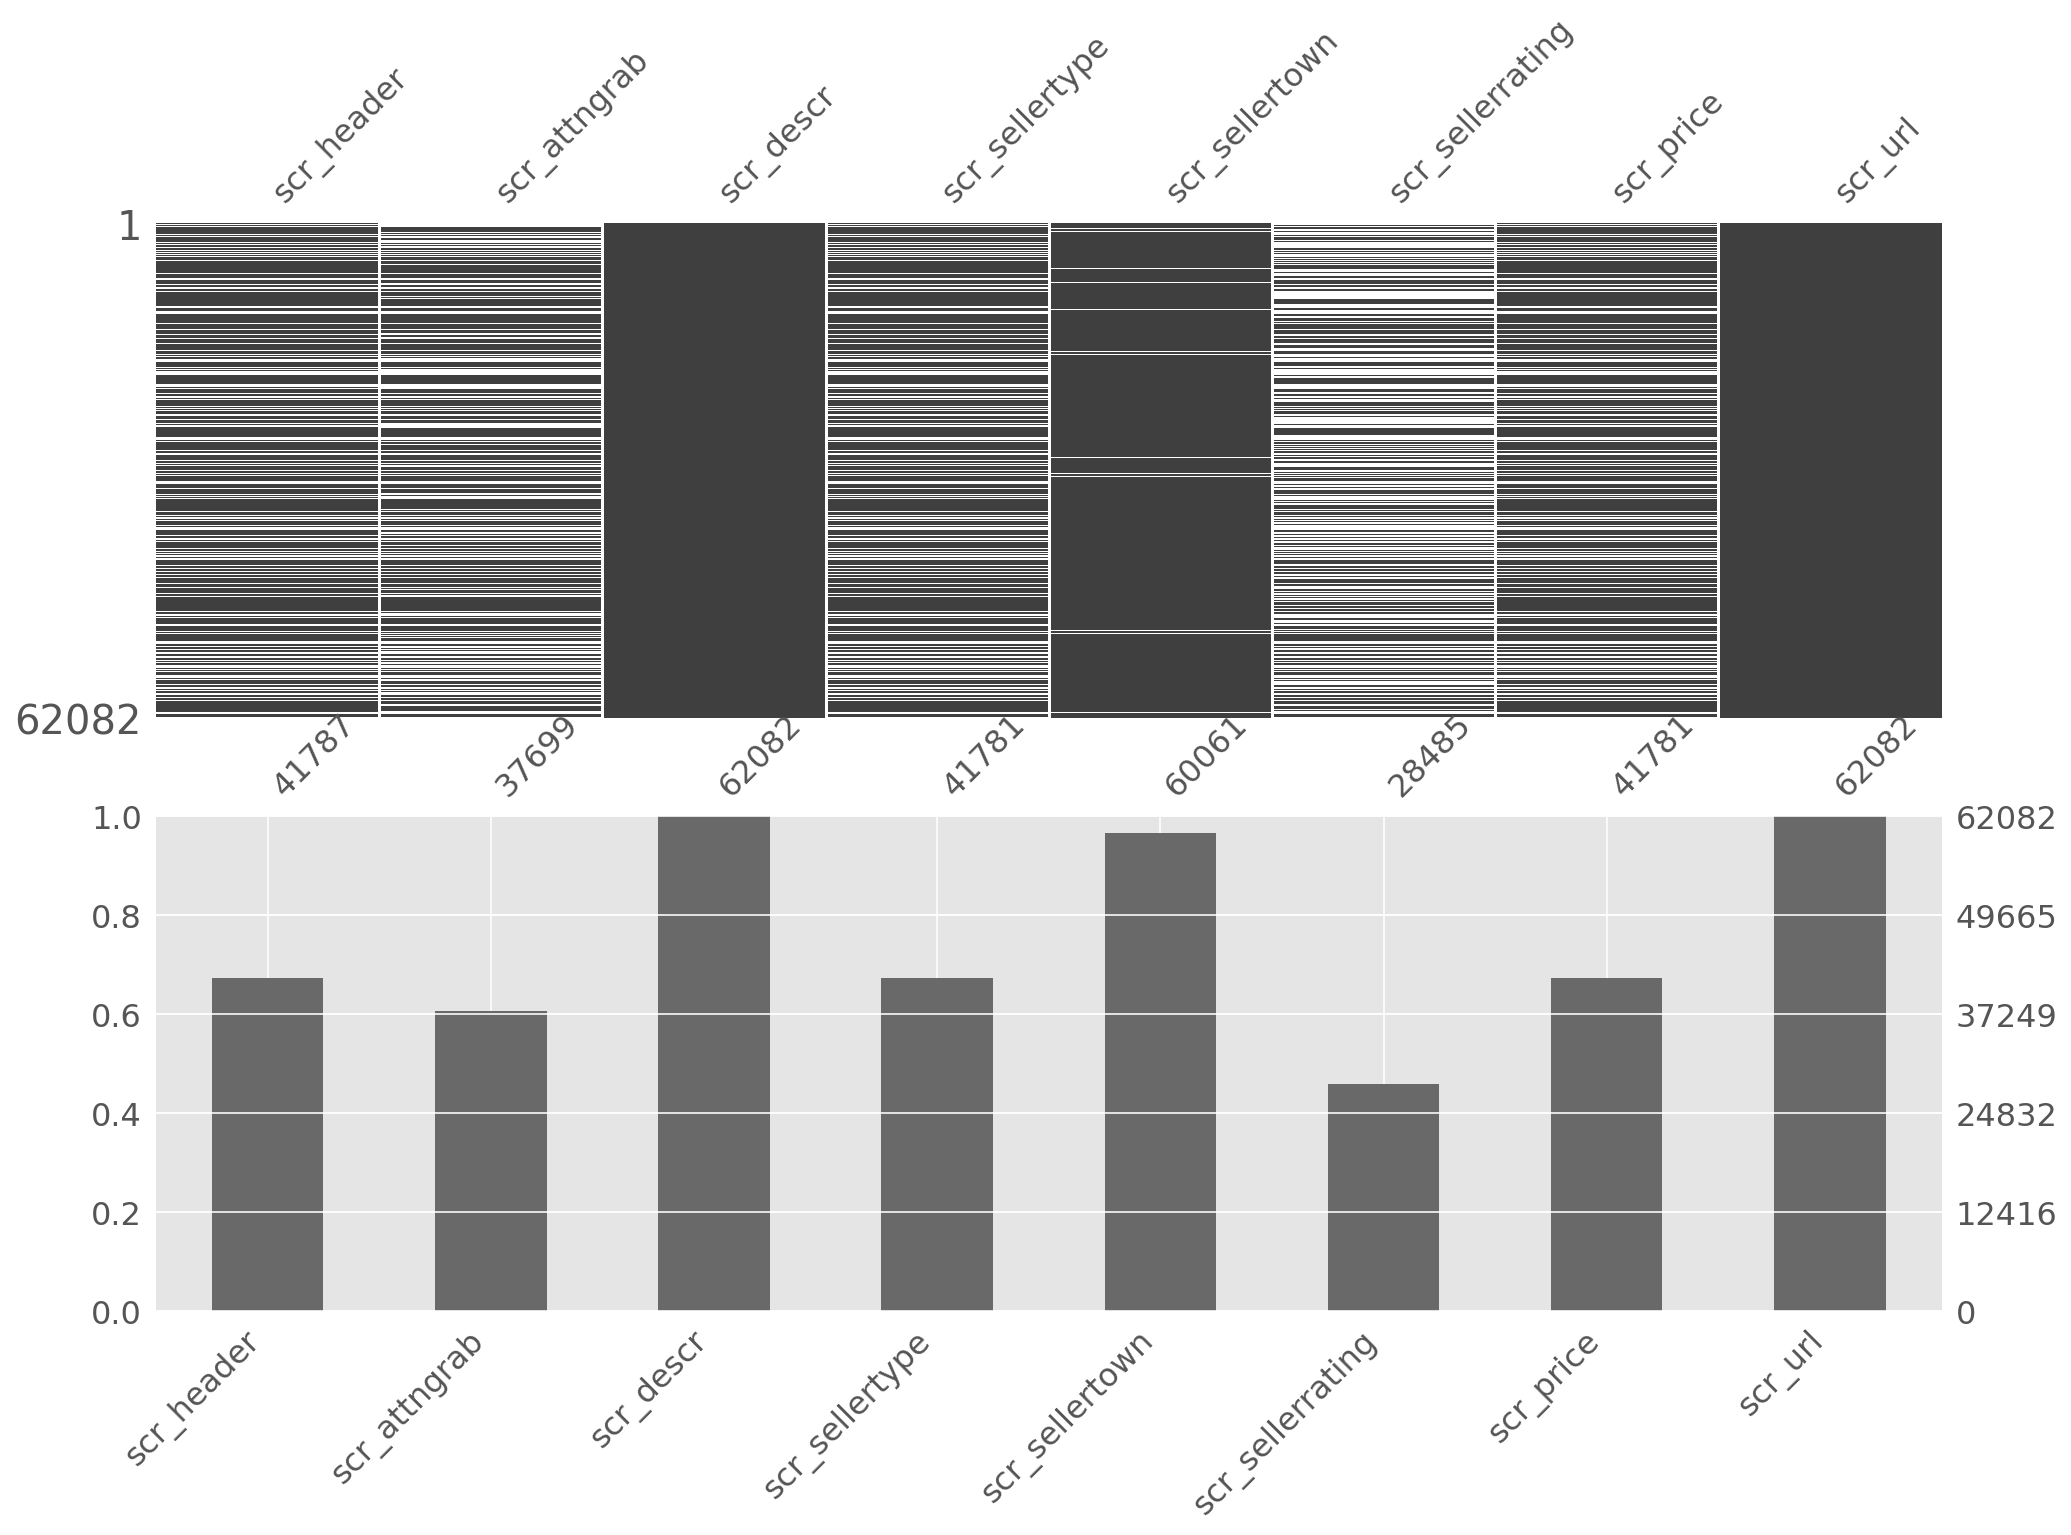

In [12]:
# visualise missing values in df_master
fig, ax = plt.subplots(2,1, figsize=(16,10))

msno.matrix(df_master, ax=ax[0])
msno.bar(df_master, ax=ax[1]);

In [13]:
# original df_master
print('before dropping duplicates:', df_master.shape)

# drop duplicates
df = df_master.drop_duplicates(ignore_index=True)
print('after dropping duplicates:', df.shape)
#df.head()

# drop null values
df = df.dropna().reset_index()
df.drop(columns='index', inplace=True)

print('after dropping null values:', df.shape)
display(df.head())

before dropping duplicates: (62082, 8)
after dropping duplicates: (47821, 8)
after dropping null values: (16262, 8)


,scr_header,scr_attngrab,scr_descr,scr_sellertype,scr_sellertown,scr_sellerrating,scr_price,scr_url
0,Audi A4 Avant 2.0 TDI S line Special Edition 5dr,"FULL S/HIST, NEW MOT, EXTRAS","['2008 (57 reg)', 'Estate', '115,000 miles', '...",Trade seller - \nSee all 42 cars,brighton,5.0,"£3,995",/dealers/east-sussex/brighton/browns-autos-100...
1,Audi A3 1.6 TDI Sport Sportback S Tronic 5dr,AUTO!! FSH!!,"['2011 (61 reg)', 'Hatchback', '112,988 miles'...",Trade seller - \nSee all 11 cars,bishop's stortford,4.9,"£4,799",/dealers/hertfordshire/bishops-stortford/watso...
2,Audi Q3 2.0 TFSI SE quattro 5dr,Immaculate condition Must see,"['2011 (61 reg)', 'SUV', '96,000 miles', '2.0L...",Trade seller - \nSee all 6 cars,stepney,4.8,"£8,740",/dealers/tower-hamlets/stepney/sutsi-cars-1001...
3,Audi A6 TDI ULTRA S LINE 2.0 4dr,Sat Nav Ready,"['2015 (65 reg)', 'Saloon', '97,837 miles', '2...",Trade seller - \nSee all 1450 cars,chatham,4.6,"£10,900",/dealers/kent/chatham/big-motoring-world-10007657
4,Audi A5 1.8 TFSI Sport 2dr,PARKING SENSORS LEATHER SEATS,"['2009 (58 reg)', 'Coupe', '67,345 miles', '1....",Trade seller - \nSee all 91 cars,wandsworth,5.0,"£6,491",/dealers/borough-of-wandsworth/wandsworth/smar...


In [14]:
# extract info from description column, to generate new columns
def year(x):
    pattern = re.compile(r'(\d{4})')
    element = re.findall(pattern, x)
    try:
        return int(element[0])
    except:
        return np.nan

def reg_num(x):
    pattern = re.compile(r'(\d\d reg)')
    element = re.findall(pattern, x)
    try:
        return int(element[0].split()[0])
    except:
        return np.nan

def body_style(x):
    list_x = ast.literal_eval(x)
    return list_x[1].lower()

# def body_style(x):
#     return x.split(',')[1].strip().strip("'").lower()

def mileage(x):
    pattern = re.compile(r'(\d\S+ miles)')
    element = re.findall(pattern, x)
    try:
        return int(element[0].split()[0].replace(',', ''))
    except:
        return np.nan

def engine_size(x):
    pattern = re.compile(r'(\d\S+L)')
    element = re.findall(pattern, x)
    try:
        return float(element[0][:-1])
    except:
        return np.nan

def horse_power(x):
    try:
        #find patterns with 'bhp' or 'ps' (1 ps = 98.6% of bhp, so treat as equivalent)
        pattern = re.compile(r'(\d\S+BHP|\d\S+PS)')
        element = re.findall(pattern, x)[0]
        #extract digits only and return as int
        pattern = re.compile(r'(\d+)')
        digits = re.findall(pattern, element)    
        return int(digits[0])
    except:
        return np.nan

def transmission(x):
    try:
        pattern = re.compile(r'(Manual|Automatic|MT|AT)')
        element = re.findall(pattern, x)[0]
        return element.lower()
    except:
        return np.nan

def fuel_type(x):
    try:
        pattern = re.compile(r'(Petrol|Diesel)')
        element = re.findall(pattern, x)[0]
        return element.lower()
    except:
        return np.nan

def num_owners(x):
    try:
        pattern = re.compile(r'(\d+ owner)')
        element = re.findall(pattern, x)[0]
        return int(element.split()[0])
    except:
        return np.nan

def ulez(x):
    if 'ULEZ' in x or 'ulez' in x:
        return 1
    else:
        return 0

df['year'] = df.scr_descr.apply(lambda x: year(x))
df['reg_num'] = df.scr_descr.apply(lambda x: reg_num(x))
df['body'] = df.scr_descr.apply(lambda x: body_style(x))
df['mileage'] = df.scr_descr.apply(lambda x: mileage(x))
df['engine_size'] = df.scr_descr.apply(lambda x: engine_size(x))
df['horsepower'] = df.scr_descr.apply(lambda x: horse_power(x))
df['transmission'] = df.scr_descr.apply(lambda x: transmission(x))
df['fuel'] = df.scr_descr.apply(lambda x: fuel_type(x))
df['owners'] = df.scr_descr.apply(lambda x: num_owners(x))
df['ulez'] = df.scr_descr.apply(lambda x: ulez(x))


# extract seller type and price (in int form)
def sellertype(x):
    if 'Trade' in x or 'trade' in x:
        return 'trade_seller'
    if 'Approved' in x or 'approved' in x:
        return 'approved_dealer'
    
def price(x):
    return int(x[1:].replace(',', ''))

df['seller_type'] = df.scr_sellertype.apply(lambda x: sellertype(x))
df['price'] = df.scr_price.apply(lambda x: price(x))

df.head(3)

,scr_header,scr_attngrab,scr_descr,scr_sellertype,scr_sellertown,scr_sellerrating,scr_price,scr_url,year,reg_num,body,mileage,engine_size,horsepower,transmission,fuel,owners,ulez,seller_type,price
0,Audi A4 Avant 2.0 TDI S line Special Edition 5dr,"FULL S/HIST, NEW MOT, EXTRAS","['2008 (57 reg)', 'Estate', '115,000 miles', '...",Trade seller - \nSee all 42 cars,brighton,5.0,"£3,995",/dealers/east-sussex/brighton/browns-autos-100...,2008.0,57.0,estate,115000.0,2.0,168.0,manual,diesel,6.0,0,trade_seller,3995
1,Audi A3 1.6 TDI Sport Sportback S Tronic 5dr,AUTO!! FSH!!,"['2011 (61 reg)', 'Hatchback', '112,988 miles'...",Trade seller - \nSee all 11 cars,bishop's stortford,4.9,"£4,799",/dealers/hertfordshire/bishops-stortford/watso...,2011.0,61.0,hatchback,112988.0,1.6,104.0,automatic,diesel,3.0,0,trade_seller,4799
2,Audi Q3 2.0 TFSI SE quattro 5dr,Immaculate condition Must see,"['2011 (61 reg)', 'SUV', '96,000 miles', '2.0L...",Trade seller - \nSee all 6 cars,stepney,4.8,"£8,740",/dealers/tower-hamlets/stepney/sutsi-cars-1001...,2011.0,61.0,suv,96000.0,2.0,168.0,manual,petrol,2.0,1,trade_seller,8740


In [15]:
# 'body' shows some wrongly entered values (eg engine size: '1.5l', '2.2l' etc)
df.body.value_counts()[:30]

hatchback       6593
suv             4434
saloon          1543
coupe           1086
convertible      829
estate           683
mpv              476
pickup           262
1.5l              58
2.2l              46
1.4l              42
2.0l              36
1.6l              26
1.0l              24
limousine         16
143ps             13
2.5l              10
panel van          7
1.9l               6
1.2l               5
combi van          5
0.9l               4
3.5l               3
10,000 miles       2
156ps              2
101 miles          2
30 miles           1
1,299 miles        1
8,854 miles        1
25,828 miles       1
Name: body, dtype: int64

In [16]:
# correct body style from engine size (eg 1.5l, 2.2l) to actual body style
def body_style_corrected(x):
    list_x = ast.literal_eval(x)
    return list_x[0].lower()

df.loc[df.body.str.contains('(\d.\dl)'), 'body'] = df.scr_descr.apply(lambda x: body_style_corrected(x))

/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [17]:
# df = df where 'body' does not contain digits (ie delete all rows with digits in body column)
df = df[~df.body.str.contains('(\d)')]

# reset index inplace
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.body.value_counts()

(16199, 20)


hatchback          6653
suv                4583
saloon             1547
coupe              1091
convertible         833
estate              695
mpv                 476
pickup              291
limousine            16
panel van             7
combi van             5
car derived van       1
window van            1
Name: body, dtype: int64

In [18]:
# extract make and model from scr_header column
def make(x):
    return x.split()[0].lower()

def model(x):
    return x.split()[1].lower()

df['make'] = df.scr_header.apply(lambda x: make(x))
df['model'] = df.scr_header.apply(lambda x: model(x))

df.head(3)

,scr_header,scr_attngrab,scr_descr,scr_sellertype,scr_sellertown,scr_sellerrating,scr_price,scr_url,year,reg_num,...,engine_size,horsepower,transmission,fuel,owners,ulez,seller_type,price,make,model
0,Audi A4 Avant 2.0 TDI S line Special Edition 5dr,"FULL S/HIST, NEW MOT, EXTRAS","['2008 (57 reg)', 'Estate', '115,000 miles', '...",Trade seller - \nSee all 42 cars,brighton,5.0,"£3,995",/dealers/east-sussex/brighton/browns-autos-100...,2008.0,57.0,...,2.0,168.0,manual,diesel,6.0,0,trade_seller,3995,audi,a4
1,Audi A3 1.6 TDI Sport Sportback S Tronic 5dr,AUTO!! FSH!!,"['2011 (61 reg)', 'Hatchback', '112,988 miles'...",Trade seller - \nSee all 11 cars,bishop's stortford,4.9,"£4,799",/dealers/hertfordshire/bishops-stortford/watso...,2011.0,61.0,...,1.6,104.0,automatic,diesel,3.0,0,trade_seller,4799,audi,a3
2,Audi Q3 2.0 TFSI SE quattro 5dr,Immaculate condition Must see,"['2011 (61 reg)', 'SUV', '96,000 miles', '2.0L...",Trade seller - \nSee all 6 cars,stepney,4.8,"£8,740",/dealers/tower-hamlets/stepney/sutsi-cars-1001...,2011.0,61.0,...,2.0,168.0,manual,petrol,2.0,1,trade_seller,8740,audi,q3


In [19]:
# correct make names for those with more than one word as the make name
double_car_names = ['land', 'aston', 'alfa', 'great']

indexer = df[df.make == 'land'].index
df.iloc[indexer, -2] = 'landrover'

indexer = df[df.make == 'aston'].index
df.iloc[indexer, -2] = 'astonmartin'

indexer = df[df.make == 'alfa'].index
df.iloc[indexer, -2] = 'alfaromeo'

indexer = df[df.make == 'great'].index
df.iloc[indexer, -2] = 'greatwall'

In [20]:
sorted(df.make.unique())

['abarth',
 'alfaromeo',
 'alpine',
 'astonmartin',
 'audi',
 'austin',
 'bentley',
 'bmw',
 'bristol',
 'bugatti',
 'cadillac',
 'caterham',
 'chevrolet',
 'chrysler',
 'citroen',
 'corvette',
 'cupra',
 'dacia',
 'daewoo',
 'daihatsu',
 'daimler',
 'dodge',
 'ds',
 'ferrari',
 'fiat',
 'ford',
 'gentry',
 'greatwall',
 'holden',
 'honda',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'lamborghini',
 'landrover',
 'lexus',
 'lincoln',
 'london',
 'lotus',
 'maserati',
 'maybach',
 'mazda',
 'mazda2',
 'mazda3',
 'mazda5',
 'mazda6',
 'mclaren',
 'mercedes-benz',
 'mg',
 'mini',
 'mitsubishi',
 'morgan',
 'morris',
 'nissan',
 'noble',
 'peugeot',
 'pilgrim',
 'porsche',
 'proton',
 'renault',
 'rolls-royce',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'ssangyong',
 'subaru',
 'suzuki',
 'tesla',
 'tiger',
 'toyota',
 'tvr',
 'vauxhall',
 'volkswagen',
 'volvo',
 'zenos']

In [21]:
df[df.make.str.contains('mazda')].make.value_counts()

mazda     250
mazda6     40
mazda3     39
mazda2     28
mazda5      9
Name: make, dtype: int64

In [22]:
indexer = df[df.make.str.contains('mazda')].index
df.iloc[indexer, -2] = 'mazda'

In [23]:
sorted(df.make.unique())

['abarth',
 'alfaromeo',
 'alpine',
 'astonmartin',
 'audi',
 'austin',
 'bentley',
 'bmw',
 'bristol',
 'bugatti',
 'cadillac',
 'caterham',
 'chevrolet',
 'chrysler',
 'citroen',
 'corvette',
 'cupra',
 'dacia',
 'daewoo',
 'daihatsu',
 'daimler',
 'dodge',
 'ds',
 'ferrari',
 'fiat',
 'ford',
 'gentry',
 'greatwall',
 'holden',
 'honda',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'lamborghini',
 'landrover',
 'lexus',
 'lincoln',
 'london',
 'lotus',
 'maserati',
 'maybach',
 'mazda',
 'mclaren',
 'mercedes-benz',
 'mg',
 'mini',
 'mitsubishi',
 'morgan',
 'morris',
 'nissan',
 'noble',
 'peugeot',
 'pilgrim',
 'porsche',
 'proton',
 'renault',
 'rolls-royce',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'ssangyong',
 'subaru',
 'suzuki',
 'tesla',
 'tiger',
 'toyota',
 'tvr',
 'vauxhall',
 'volkswagen',
 'volvo',
 'zenos']

In [24]:
df.columns

Index(['scr_header', 'scr_attngrab', 'scr_descr', 'scr_sellertype',
       'scr_sellertown', 'scr_sellerrating', 'scr_price', 'scr_url', 'year',
       'reg_num', 'body', 'mileage', 'engine_size', 'horsepower',
       'transmission', 'fuel', 'owners', 'ulez', 'seller_type', 'price',
       'make', 'model'],
      dtype='object')

In [25]:
sorted(df.engine_size.unique())

[0.9,
 1.0,
 1.1,
 1.2,
 1.25,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.4,
 2.5,
 2.6,
 2.7,
 2.9,
 3.0,
 3.1,
 3.2,
 3.4,
 3.5,
 3.6,
 3.7,
 4.0,
 4.2,
 4.4,
 4.5,
 4.8,
 5.0,
 5.5,
 6.0,
 nan,
 0.1,
 0.6,
 0.66,
 0.7,
 0.8,
 0.88,
 1.33,
 1.75,
 2.3,
 2.8,
 3.3,
 3.8,
 3.9,
 4.1,
 4.3,
 4.6,
 4.7,
 4.9,
 5.2,
 5.3,
 5.4,
 5.7,
 5.9,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 6.6,
 6.7,
 6.75,
 6.8,
 7.0,
 7.2,
 7.3,
 7.4,
 8.0,
 8.3,
 1983.0,
 2000.0]

In [26]:
# amend engine_size, which were clearly incorrectly computed
indexer = df[df.engine_size == 1983.0].index
df.iloc[indexer, -10] = 2.0

indexer = df[df.engine_size == 2000.0].index
df.iloc[indexer, -10] = 2.0

In [27]:
df.columns

Index(['scr_header', 'scr_attngrab', 'scr_descr', 'scr_sellertype',
       'scr_sellertown', 'scr_sellerrating', 'scr_price', 'scr_url', 'year',
       'reg_num', 'body', 'mileage', 'engine_size', 'horsepower',
       'transmission', 'fuel', 'owners', 'ulez', 'seller_type', 'price',
       'make', 'model'],
      dtype='object')

/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/missingno/missingno.py:60: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


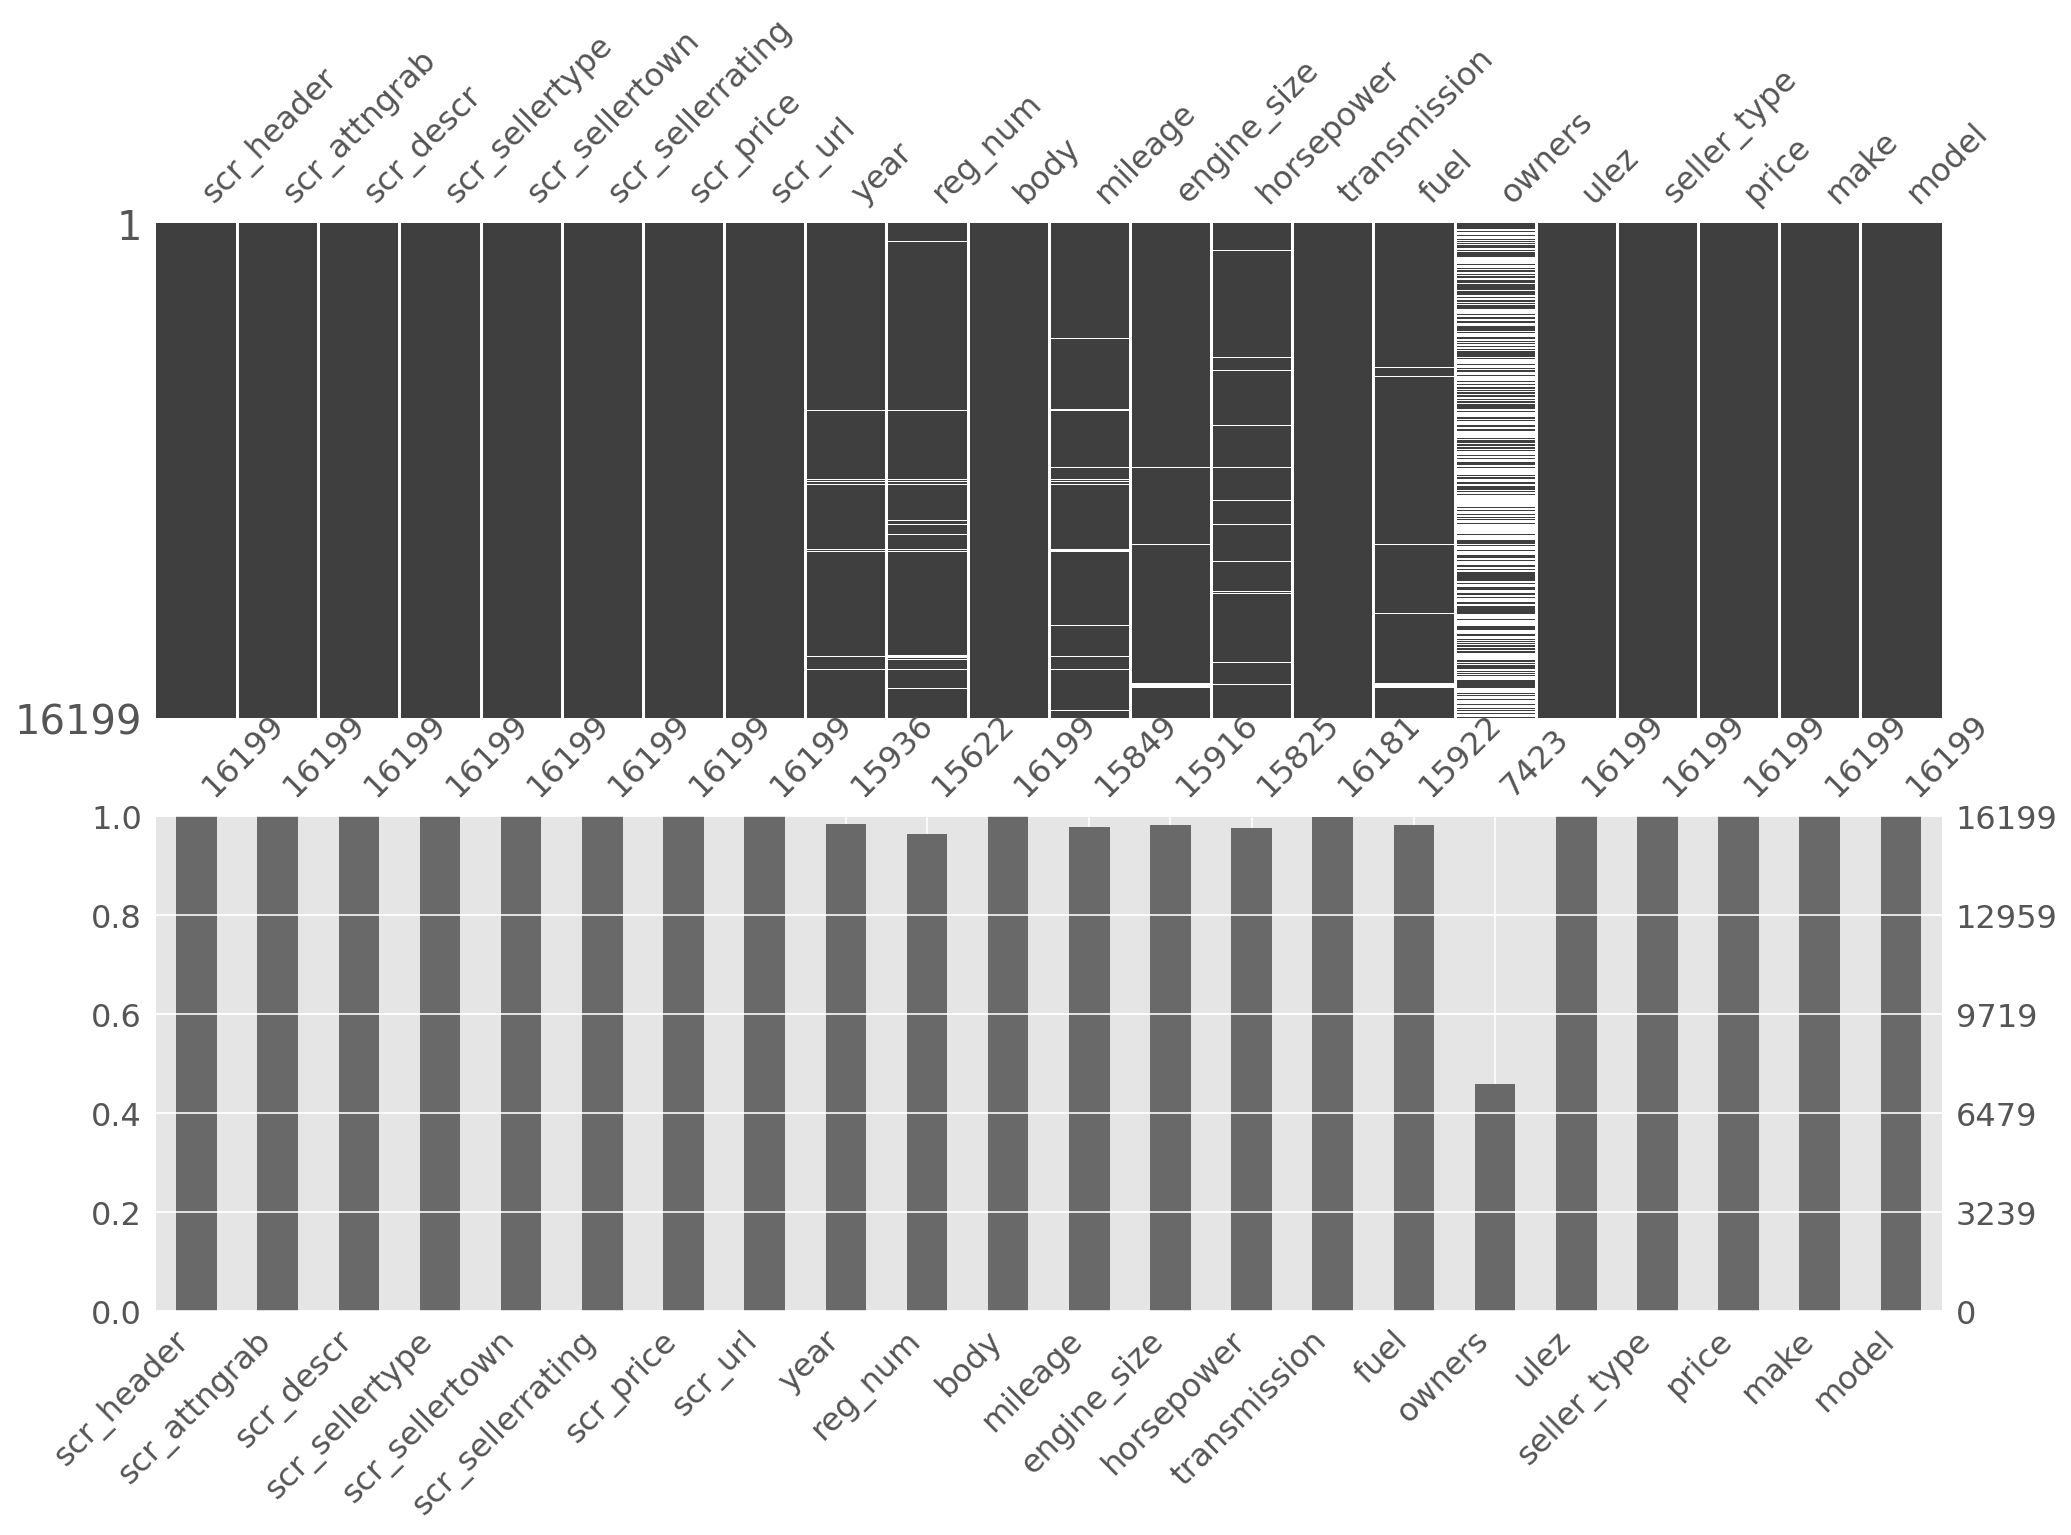

In [28]:
# visualise missing values in df_master
fig, ax = plt.subplots(2,1, figsize=(16,10))

msno.matrix(df, ax=ax[0])
msno.bar(df, ax=ax[1]);

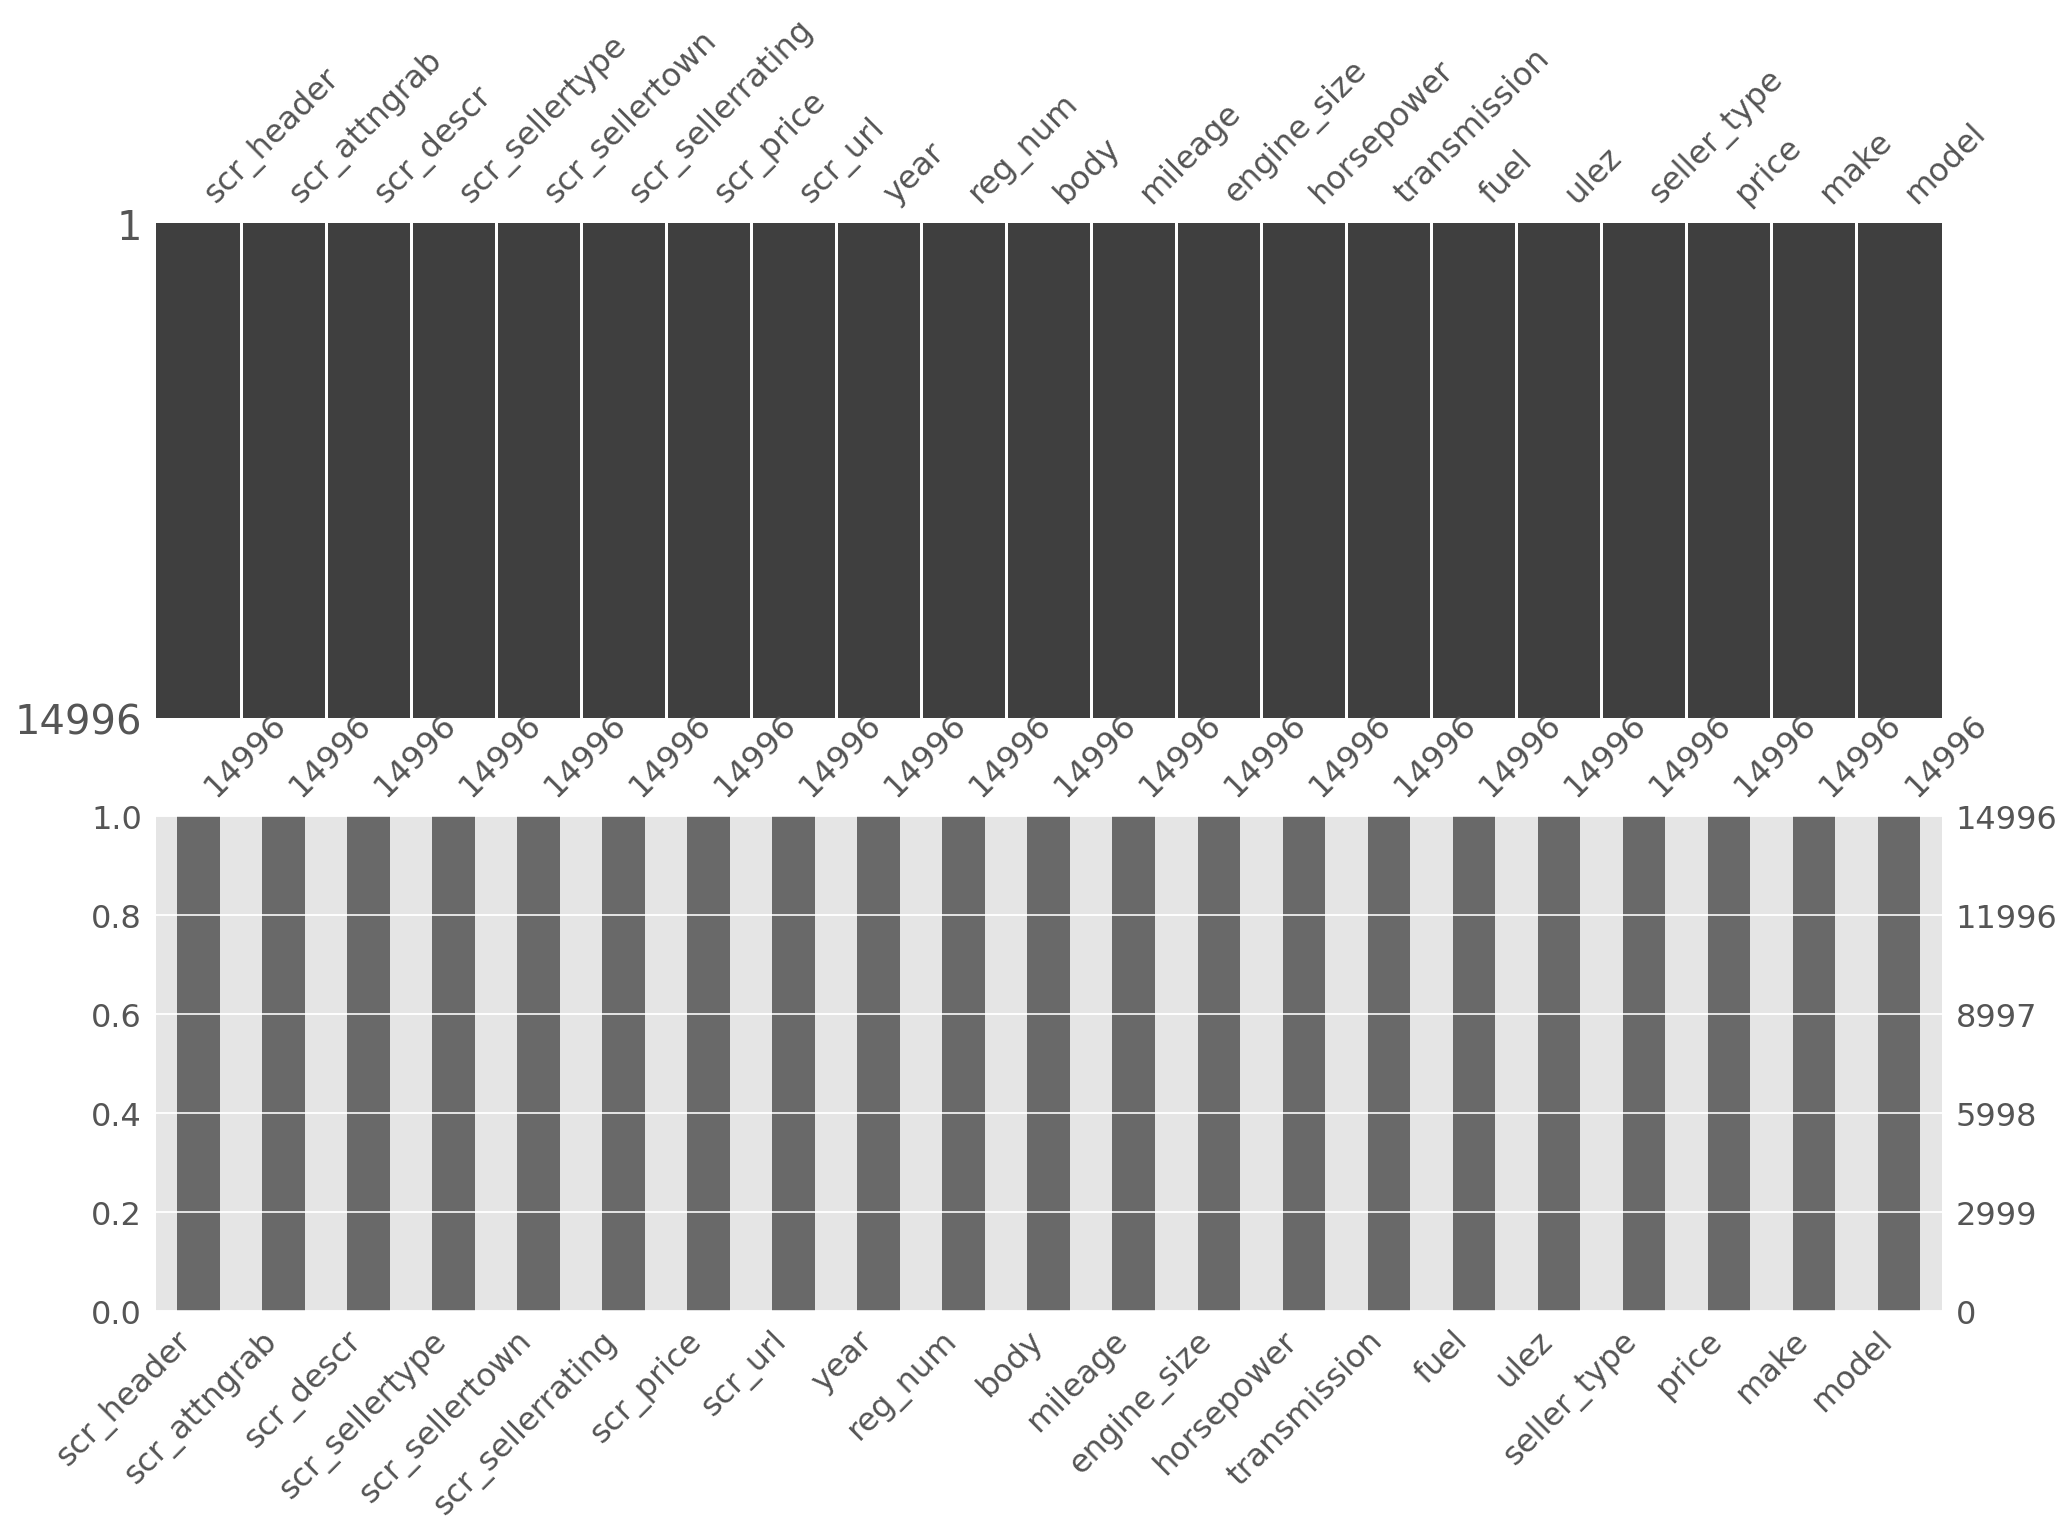

In [29]:
# drop 'owners' column (too many null entries)
df.drop(columns=['owners'], inplace=True)

# drop null rows
df.dropna(inplace=True)

# visualise missing values in df_master
fig, ax = plt.subplots(2,1, figsize=(16,10))

msno.matrix(df, ax=ax[0])
msno.bar(df, ax=ax[1]);

In [30]:
# write df to disk

to_file = '../data/df_master.csv'
df.to_csv(to_file)